In [1]:
!pip install numpy pandas matplotlib seaborn 

!pip install scikit-learn albumentations monai 

!pip install torch torchvision opencv-python
!pip install segmentation-models-pytorch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.5 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=7f254f199099a1ce7e53bb7f6d02164f254fca6be935c0e3a4cf6a62247c762f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=dfa0758333af2a42aa09e95d1f4220792f87c0a0fc2513457a2fc17a592595dc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import cv2
import pandas as pd
import glob
import gc
from tqdm import tqdm

## Konfiguracja modelu do przetwarzania obrazów i maskowania


In [ ]:
class Config:
    SEED = 42
    IMAGE_DIR = '/kaggle/input/dataset/05_Final_Ground_Truth_Data/Composite_Images'
    MASK_DIR = '/kaggle/input/dataset/05_Final_Ground_Truth_Data/Label_Images'
    OUTPUT_DIR = '/kaggle/working/predictions'
    ENCODERS = ["resnet34", "resnet50", "resnet101"]
    INPUT_CHANNELS = 3
    NUM_CLASSES = 5
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    EPOCHS = 20
    IMG_WIDTH = 224
    IMG_HEIGHT = 224
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Funkcje i klasa modelu do segmentacji obrazów z użyciem U-Net++
### Zawiera funkcje ustawiające ziarno losowości oraz mapujące maski na klasy, a także definicję modelu U-Net++ z uwagą


In [ ]:
def set_seed(seed):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def map_mask_to_class(mask):
    """Map mask pixel values to class indices."""
    class_mask = np.zeros_like(mask, dtype=np.int64)
    class_mask = np.where(mask == 50, 0, class_mask)
    class_mask = np.where(mask == 100, 1, class_mask)
    class_mask = np.where(mask == 150, 2, class_mask)
    class_mask = np.where(mask == 200, 3, class_mask)
    class_mask = np.where(mask == 250, 4, class_mask)
    return class_mask

class UNetPlusPlusWithAttention(nn.Module):
    def __init__(self, encoder_name="resnet34", in_channels=3, num_classes=5):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=num_classes
        )
        self.final_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        return self.final_activation(x)

## Przygotowanie danych do segmentacji obrazów MRI


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]))
        mask = np.array(Image.open(self.mask_paths[idx]))
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        mask = torch.tensor(map_mask_to_class(mask), dtype=torch.long)
        
        return image, mask

def load_dataset(image_dir, mask_dir):
    """Load image and mask paths."""
    image_paths = sorted(glob.glob(os.path.join(image_dir, '**', '*.png'), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '**', '*.png'), recursive=True))
    
    if not image_paths or not mask_paths:
        raise ValueError("No images or masks found in the specified directories.")
    
    return image_paths, mask_paths

def create_data_loaders(image_paths, mask_paths, test_size=0.2):
    """Create train, validation, and test data loaders."""
    set_seed(Config.SEED)

    train_images, test_images, train_masks, test_masks = train_test_split(
        image_paths, mask_paths, test_size=test_size, random_state=Config.SEED
    )
    train_images, val_images, train_masks, val_masks = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=Config.SEED
    )

    transform = A.Compose([
        A.Resize(Config.IMG_HEIGHT, Config.IMG_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    train_dataset = MRIDataset(train_images, train_masks, transform)
    val_dataset = MRIDataset(val_images, val_masks, transform)
    test_dataset = MRIDataset(test_images, test_masks, transform)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

## Funkcja obliczająca współczynnik Dice'a dla segmentacji wieloklasowej


In [ ]:
def calculate_dice_score(predictions, targets, num_classes, eps=1e-8):
    """Calculate Dice score for multi-class segmentation."""
    dice_scores = {}
    for cls in range(num_classes):
        pred_cls = (predictions == cls).float()
        target_cls = (targets == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        dice_score = (2 * intersection + eps) / (pred_cls.sum() + target_cls.sum() + eps)
        dice_scores[cls] = dice_score.item()
    
    return dice_scores

## Trenowanie

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, encoder_name):
    """Train the segmentation model."""
    weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 0.1], dtype=torch.float32).to(Config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, verbose=True
    )

    best_val_loss = float('inf')
    training_results = {
        'train_loss': [], 'train_dice_scores': [],
        'val_loss': [], 'val_dice_scores': []
    }
    test_results = {'test_loss': [], 'test_dice_scores': []}

    for epoch in range(Config.EPOCHS):
        model.train()
        train_loss, train_dice_scores = 0, {}
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{Config.EPOCHS}'):
            images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            
            batch_dice_scores = calculate_dice_score(
                predicted_classes.cpu(), masks.cpu(), Config.NUM_CLASSES
            )
            
            for cls, score in batch_dice_scores.items():
                if cls not in train_dice_scores:
                    train_dice_scores[cls] = []
                train_dice_scores[cls].append(score)

        model.eval()
        val_loss, val_dice_scores = 0, {}
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                predicted_classes = torch.argmax(outputs, dim=1)
                batch_dice_scores = calculate_dice_score(
                    predicted_classes.cpu(), masks.cpu(), Config.NUM_CLASSES
                )
                
                for cls, score in batch_dice_scores.items():
                    if cls not in val_dice_scores:
                        val_dice_scores[cls] = []
                    val_dice_scores[cls].append(score)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        avg_train_dice = {cls: np.mean(scores) for cls, scores in train_dice_scores.items()}
        avg_val_dice = {cls: np.mean(scores) for cls, scores in val_dice_scores.items()}

        print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}')
        print('Train Dice Scores:', avg_train_dice)
        print('Validation Dice Scores:', avg_val_dice)

        training_results['train_loss'].append(train_loss)
        training_results['val_loss'].append(val_loss)
        training_results['train_dice_scores'].append(avg_train_dice)
        training_results['val_dice_scores'].append(avg_val_dice)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(Config.OUTPUT_DIR, f'best_model_{encoder_name}.pth')
            os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model for {encoder_name}")

        torch.cuda.empty_cache()
        gc.collect()

    model.eval()
    test_loss, test_dice_scores = 0, {}
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
            
            predicted_classes = torch.argmax(outputs, dim=1)
            batch_dice_scores = calculate_dice_score(
                predicted_classes.cpu(), masks.cpu(), Config.NUM_CLASSES
            )
            
            for cls, score in batch_dice_scores.items():
                if cls not in test_dice_scores:
                    test_dice_scores[cls] = []
                test_dice_scores[cls].append(score)

    test_loss /= len(test_loader)
    avg_test_dice = {cls: np.mean(scores) for cls, scores in test_dice_scores.items()}
    
    test_results['test_loss'].append(test_loss)
    test_results['test_dice_scores'].append(avg_test_dice)

    print('Test Loss:', test_loss)
    print('Test Dice Scores:', avg_test_dice)

    return training_results, test_results

In [2]:
def main():
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    image_paths, mask_paths = load_dataset(Config.IMAGE_DIR, Config.MASK_DIR)
    train_loader, val_loader, test_loader = create_data_loaders(image_paths, mask_paths)

    for encoder in Config.ENCODERS:
        print(f"\nTraining with encoder: {encoder}")
        model = UNetPlusPlusWithAttention(
            encoder_name=encoder, 
            in_channels=Config.INPUT_CHANNELS, 
            num_classes=Config.NUM_CLASSES
        ).to(Config.DEVICE)
        
        training_results, test_results = train_model(
            model, train_loader, val_loader, test_loader, encoder
        )

        pd.DataFrame(training_results).to_csv(f'training_results_{encoder}.csv')
        pd.DataFrame(test_results).to_csv(f'test_results_{encoder}.csv')

if __name__ == "__main__":
    main()

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Training with encoder: resnet34


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 420MB/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 1: Train Loss 1.4277, Val Loss 1.3175
Train Dice Scores: {0: 0.5064974323876442, 1: 0.40156685777248874, 2: 0.127917684960149, 3: 0.012684928745241655, 4: 0.2668286052442366}
Validation Dice Scores: {0: 0.6370806097984314, 1: 0.5225139148533344, 2: 0.2082582926377654, 3: 0.03377974173054099, 4: 0.7806465588510036}
Saved best model for resnet34


Epoch 2/20: 100%|██████████| 62/62 [00:20<00:00,  3.02it/s]


Epoch 2: Train Loss 1.2502, Val Loss 1.1958
Train Dice Scores: {0: 0.7114809684215053, 1: 0.6324239613548401, 2: 0.3257355644337593, 3: 0.09009034066430983, 4: 0.9031470302612551}
Validation Dice Scores: {0: 0.740839634090662, 1: 0.6707203723490238, 2: 0.3910293150693178, 3: 0.17866160720586777, 4: 0.9494269900023937}
Saved best model for resnet34


Epoch 3/20: 100%|██████████| 62/62 [00:20<00:00,  3.05it/s]


Epoch 3: Train Loss 1.1550, Val Loss 1.1142
Train Dice Scores: {0: 0.7537246413769261, 1: 0.6908944066493742, 2: 0.5695584483685032, 3: 0.29375331944996314, 4: 0.9644082563538705}
Validation Dice Scores: {0: 0.7634018547832966, 1: 0.6737092398107052, 2: 0.729638110846281, 3: 0.40943439677357674, 4: 0.9718139097094536}
Saved best model for resnet34


Epoch 4/20: 100%|██████████| 62/62 [00:20<00:00,  3.07it/s]


Epoch 4: Train Loss 1.0810, Val Loss 1.0542
Train Dice Scores: {0: 0.799705889917189, 1: 0.7283252689146227, 2: 0.8685541114499492, 3: 0.49070779738887665, 4: 0.9787459536906211}
Validation Dice Scores: {0: 0.8189796358346939, 1: 0.7817253209650517, 2: 0.8912083692848682, 3: 0.5614831000566483, 4: 0.9835239201784134}
Saved best model for resnet34


Epoch 5/20: 100%|██████████| 62/62 [00:19<00:00,  3.10it/s]


Epoch 5: Train Loss 1.0258, Val Loss 1.0086
Train Dice Scores: {0: 0.8215311313829115, 1: 0.7857214827691356, 2: 0.9065127113173085, 3: 0.6019650120888987, 4: 0.9840559074955602}
Validation Dice Scores: {0: 0.8064438700675964, 1: 0.8070536740124226, 2: 0.9024544134736061, 3: 0.6162996590137482, 4: 0.983944084495306}
Saved best model for resnet34


Epoch 6/20: 100%|██████████| 62/62 [00:19<00:00,  3.15it/s]


Epoch 6: Train Loss 0.9894, Val Loss 0.9785
Train Dice Scores: {0: 0.8732829603456682, 1: 0.823133215788872, 2: 0.9131348719519954, 3: 0.6631262167807548, 4: 0.9886709317084281}
Validation Dice Scores: {0: 0.9166722036898136, 1: 0.8385726511478424, 2: 0.9107999876141548, 3: 0.687090553343296, 4: 0.991663433611393}
Saved best model for resnet34


Epoch 7/20: 100%|██████████| 62/62 [00:20<00:00,  3.08it/s]


Epoch 7: Train Loss 0.9674, Val Loss 0.9618
Train Dice Scores: {0: 0.9191216836052556, 1: 0.8469854227958187, 2: 0.9193322783516299, 3: 0.6943469172523867, 4: 0.9919062641359144}
Validation Dice Scores: {0: 0.9255823083221912, 1: 0.836111556738615, 2: 0.9095751568675041, 3: 0.6774026453495026, 4: 0.9918103218078613}
Saved best model for resnet34


Epoch 8/20: 100%|██████████| 62/62 [00:19<00:00,  3.16it/s]


Epoch 8: Train Loss 0.9546, Val Loss 0.9533
Train Dice Scores: {0: 0.9218854183150876, 1: 0.8617816355920607, 2: 0.9220365208964194, 3: 0.7096461817141502, 4: 0.9925041794776917}
Validation Dice Scores: {0: 0.9117322117090225, 1: 0.8202296234667301, 2: 0.9145684093236923, 3: 0.6653500758111477, 4: 0.9905111864209175}
Saved best model for resnet34


Epoch 9/20: 100%|██████████| 62/62 [00:19<00:00,  3.12it/s]


Epoch 9: Train Loss 0.9459, Val Loss 0.9563
Train Dice Scores: {0: 0.9267216815102485, 1: 0.8729750754371766, 2: 0.925309338877278, 3: 0.7186739060186571, 4: 0.9930735913015181}
Validation Dice Scores: {0: 0.7493638917803764, 1: 0.8856432102620602, 2: 0.9154642447829247, 3: 0.7089915759861469, 4: 0.9828917160630226}


Epoch 10/20: 100%|██████████| 62/62 [00:19<00:00,  3.20it/s]


Epoch 10: Train Loss 0.9398, Val Loss 0.9448
Train Dice Scores: {0: 0.9313496082059799, 1: 0.882677028256078, 2: 0.9286831175127337, 3: 0.7303100958947213, 4: 0.9935744279815305}
Validation Dice Scores: {0: 0.8246298395097256, 1: 0.8835738264024258, 2: 0.9169786162674427, 3: 0.7170069739222527, 4: 0.9878002777695656}
Saved best model for resnet34


Epoch 11/20: 100%|██████████| 62/62 [00:19<00:00,  3.13it/s]


Epoch 11: Train Loss 0.9363, Val Loss 0.9382
Train Dice Scores: {0: 0.9330605960661366, 1: 0.8880386314084453, 2: 0.9292918693634772, 3: 0.7349130347851784, 4: 0.9937811003577325}
Validation Dice Scores: {0: 0.9215022660791874, 1: 0.8871067389845848, 2: 0.9177139401435852, 3: 0.6906891167163849, 4: 0.9928777366876602}
Saved best model for resnet34


Epoch 12/20: 100%|██████████| 62/62 [00:20<00:00,  3.09it/s]


Epoch 12: Train Loss 0.9331, Val Loss 0.9382
Train Dice Scores: {0: 0.9333402168366217, 1: 0.8947267811144551, 2: 0.9318420550515575, 3: 0.7403473027290837, 4: 0.9939463196262237}
Validation Dice Scores: {0: 0.925186850130558, 1: 0.874162670224905, 2: 0.9212188646197319, 3: 0.7232935577630997, 4: 0.9930855967104435}
Saved best model for resnet34


Epoch 13/20: 100%|██████████| 62/62 [00:19<00:00,  3.15it/s]


Epoch 13: Train Loss 0.9307, Val Loss 0.9329
Train Dice Scores: {0: 0.9372609103879621, 1: 0.8965316376378459, 2: 0.93347141723479, 3: 0.7437953862451738, 4: 0.9942008766435808}
Validation Dice Scores: {0: 0.9389885291457176, 1: 0.8953626789152622, 2: 0.9153680987656116, 3: 0.7381581924855709, 4: 0.9944713078439236}
Saved best model for resnet34


Epoch 14/20: 100%|██████████| 62/62 [00:19<00:00,  3.12it/s]


Epoch 14: Train Loss 0.9284, Val Loss 0.9304
Train Dice Scores: {0: 0.9412217745857854, 1: 0.9019543874648309, 2: 0.9346126625614781, 3: 0.751811525514049, 4: 0.9945203758055164}
Validation Dice Scores: {0: 0.9354408606886864, 1: 0.8839008398354053, 2: 0.9232185371220112, 3: 0.7405122481286526, 4: 0.9939402677118778}
Saved best model for resnet34


Epoch 15/20: 100%|██████████| 62/62 [00:19<00:00,  3.15it/s]


Epoch 15: Train Loss 0.9272, Val Loss 0.9296
Train Dice Scores: {0: 0.9446018069021164, 1: 0.903343899596122, 2: 0.9364184746819157, 3: 0.7555748541508952, 4: 0.994731419509457}
Validation Dice Scores: {0: 0.9265113845467567, 1: 0.8805958293378353, 2: 0.9213286824524403, 3: 0.7187573872506618, 4: 0.9933122657239437}
Saved best model for resnet34


Epoch 16/20: 100%|██████████| 62/62 [00:19<00:00,  3.16it/s]


Epoch 16: Train Loss 0.9257, Val Loss 0.9297
Train Dice Scores: {0: 0.9443625115579174, 1: 0.9076971450159627, 2: 0.9378100316370687, 3: 0.7601303525509373, 4: 0.9948265533293447}
Validation Dice Scores: {0: 0.9404095336794853, 1: 0.8612854592502117, 2: 0.922165222465992, 3: 0.7368250265717506, 4: 0.9936340786516666}


Epoch 17/20: 100%|██████████| 62/62 [00:20<00:00,  3.09it/s]


Epoch 17: Train Loss 0.9242, Val Loss 0.9279
Train Dice Scores: {0: 0.9498646393898995, 1: 0.9078665029618048, 2: 0.9386248242470526, 3: 0.7644274100180595, 4: 0.9950813006970191}
Validation Dice Scores: {0: 0.9408162385225296, 1: 0.8929444514214993, 2: 0.9227550365030766, 3: 0.7478252723813057, 4: 0.994437325745821}
Saved best model for resnet34


Epoch 18/20: 100%|██████████| 62/62 [00:19<00:00,  3.15it/s]


Epoch 18: Train Loss 0.9234, Val Loss 0.9285
Train Dice Scores: {0: 0.9507999487461583, 1: 0.912717358719918, 2: 0.9400086181779062, 3: 0.7682199285876367, 4: 0.9952446760669831}
Validation Dice Scores: {0: 0.9105629026889801, 1: 0.900090254843235, 2: 0.9223047569394112, 3: 0.7271953821182251, 4: 0.9929225258529186}


Epoch 19/20: 100%|██████████| 62/62 [00:19<00:00,  3.13it/s]


Epoch 19: Train Loss 0.9223, Val Loss 0.9282
Train Dice Scores: {0: 0.9529654758591806, 1: 0.9136352971676858, 2: 0.9418978700714726, 3: 0.7697822788069325, 4: 0.995349487950725}
Validation Dice Scores: {0: 0.9474050402641296, 1: 0.9163462109863758, 2: 0.9177602455019951, 3: 0.7556063495576382, 4: 0.9954061694443226}


Epoch 20/20: 100%|██████████| 62/62 [00:20<00:00,  3.07it/s]


Epoch 20: Train Loss 0.9216, Val Loss 0.9252
Train Dice Scores: {0: 0.9532902183071259, 1: 0.9171110285866645, 2: 0.9433094551486354, 3: 0.7766531340537532, 4: 0.9954725484694203}
Validation Dice Scores: {0: 0.9495222046971321, 1: 0.892470084130764, 2: 0.9251822493970394, 3: 0.7487704753875732, 4: 0.9947980083525181}
Saved best model for resnet34
Test Loss: 0.9242850601673126
Test Dice Scores: {0: 0.9566563218832016, 1: 0.8937254279851914, 2: 0.9257421731948853, 3: 0.7396376699209213, 4: 0.9951415061950684}

Training with encoder: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 369MB/s]
Epoch 1/20: 100%|██████████| 62/62 [00:31<00:00,  1.94it/s]


Epoch 1: Train Loss 1.3122, Val Loss 1.1937
Train Dice Scores: {0: 0.4180264587123548, 1: 0.48272887719494684, 2: 0.03135365862849979, 3: 0.12572891657210647, 4: 0.7579446112917315}
Validation Dice Scores: {0: 0.5784336738288403, 1: 0.6443191431462765, 2: 0.09403094556182623, 3: 0.25397899746894836, 4: 0.9178702346980572}
Saved best model for resnet50


Epoch 2/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 2: Train Loss 1.1448, Val Loss 1.1047
Train Dice Scores: {0: 0.6955304107358379, 1: 0.7229248198770708, 2: 0.2347175315503151, 3: 0.38327411105555875, 4: 0.9567516667227591}
Validation Dice Scores: {0: 0.7260280326008797, 1: 0.7732217460870743, 2: 0.4371999278664589, 3: 0.5090850610285997, 4: 0.9733599126338959}
Saved best model for resnet50


Epoch 3/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 3: Train Loss 1.0660, Val Loss 1.0380
Train Dice Scores: {0: 0.8396962554224076, 1: 0.8153238181144961, 2: 0.6214028539196137, 3: 0.5792963841269093, 4: 0.9848977933006902}
Validation Dice Scores: {0: 0.8842118941247463, 1: 0.8347695805132389, 2: 0.6939146034419537, 3: 0.6736312173306942, 4: 0.9897672794759274}
Saved best model for resnet50


Epoch 4/20: 100%|██████████| 62/62 [00:31<00:00,  1.94it/s]


Epoch 4: Train Loss 1.0137, Val Loss 0.9996
Train Dice Scores: {0: 0.8922119131011348, 1: 0.8488496099748919, 2: 0.712335471184023, 3: 0.6781786718676167, 4: 0.9905723227608588}
Validation Dice Scores: {0: 0.9036761894822121, 1: 0.8368359953165054, 2: 0.693783413618803, 3: 0.6916267909109592, 4: 0.9909335076808929}
Saved best model for resnet50


Epoch 5/20: 100%|██████████| 62/62 [00:32<00:00,  1.94it/s]


Epoch 5: Train Loss 0.9833, Val Loss 0.9770
Train Dice Scores: {0: 0.9133072168596329, 1: 0.8682714229629885, 2: 0.7405903695091125, 3: 0.6784151244548059, 4: 0.9920053981965588}
Validation Dice Scores: {0: 0.8932115733623505, 1: 0.8687634915113449, 2: 0.805461797863245, 3: 0.6575013212859631, 4: 0.9910746775567532}
Saved best model for resnet50


Epoch 6/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 6: Train Loss 0.9653, Val Loss 0.9621
Train Dice Scores: {0: 0.9298262653812286, 1: 0.8777359800954019, 2: 0.8825252863668627, 3: 0.6915101130162516, 4: 0.993647882053929}
Validation Dice Scores: {0: 0.926298588514328, 1: 0.8913458064198494, 2: 0.884710356593132, 3: 0.7073263637721539, 4: 0.9939384423196316}
Saved best model for resnet50


Epoch 7/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 7: Train Loss 0.9549, Val Loss 0.9532
Train Dice Scores: {0: 0.9251002698175369, 1: 0.8869679281788487, 2: 0.9003748191941169, 3: 0.7069187702671174, 4: 0.9937031845892629}
Validation Dice Scores: {0: 0.920845802873373, 1: 0.891969408839941, 2: 0.8983789794147015, 3: 0.6953745186328888, 4: 0.9936092458665371}
Saved best model for resnet50


Epoch 8/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 8: Train Loss 0.9469, Val Loss 0.9460
Train Dice Scores: {0: 0.9371248425975922, 1: 0.8914412798420075, 2: 0.9084434989959963, 3: 0.7138068791358702, 4: 0.994398771755157}
Validation Dice Scores: {0: 0.9330085180699825, 1: 0.8942165225744247, 2: 0.902644582092762, 3: 0.7214667238295078, 4: 0.9944674409925938}
Saved best model for resnet50


Epoch 9/20: 100%|██████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 9: Train Loss 0.9412, Val Loss 0.9411
Train Dice Scores: {0: 0.937445992423642, 1: 0.9008183354331601, 2: 0.9228116398857485, 3: 0.7441804014867351, 4: 0.99453188719288}
Validation Dice Scores: {0: 0.9393181651830673, 1: 0.8919307515025139, 2: 0.9061115719377995, 3: 0.7348585985600948, 4: 0.9943872019648552}
Saved best model for resnet50


Epoch 10/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 10: Train Loss 0.9360, Val Loss 0.9383
Train Dice Scores: {0: 0.9403204216111091, 1: 0.9047093343350195, 2: 0.9284611305882854, 3: 0.7533691717732337, 4: 0.9946767562820066}
Validation Dice Scores: {0: 0.9278213158249855, 1: 0.9105392172932625, 2: 0.9080505706369877, 3: 0.7483107000589371, 4: 0.994336549192667}
Saved best model for resnet50


Epoch 11/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 11: Train Loss 0.9328, Val Loss 0.9362
Train Dice Scores: {0: 0.9415029335406518, 1: 0.910040961157891, 2: 0.9336508079882591, 3: 0.762417717326072, 4: 0.9948356459217687}
Validation Dice Scores: {0: 0.949178222566843, 1: 0.9024005346000195, 2: 0.915804173797369, 3: 0.7343967035412788, 4: 0.9950195550918579}
Saved best model for resnet50


Epoch 12/20: 100%|██████████| 62/62 [00:31<00:00,  1.98it/s]


Epoch 12: Train Loss 0.9303, Val Loss 0.9349
Train Dice Scores: {0: 0.9461856051798789, 1: 0.9121274534733065, 2: 0.9351484314087899, 3: 0.7644908831965539, 4: 0.9951041677305775}
Validation Dice Scores: {0: 0.9449209608137608, 1: 0.907263770699501, 2: 0.916015088558197, 3: 0.741461768746376, 4: 0.994918379932642}
Saved best model for resnet50


Epoch 13/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 13: Train Loss 0.9280, Val Loss 0.9326
Train Dice Scores: {0: 0.9447531277133573, 1: 0.9146039245590087, 2: 0.9383212693275944, 3: 0.7705983798350057, 4: 0.9950744807720184}
Validation Dice Scores: {0: 0.9502989649772644, 1: 0.8820367120206356, 2: 0.9108105860650539, 3: 0.7532272823154926, 4: 0.9948563389480114}
Saved best model for resnet50


Epoch 14/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 14: Train Loss 0.9264, Val Loss 0.9301
Train Dice Scores: {0: 0.945230875284441, 1: 0.9171202355815519, 2: 0.9401545168892029, 3: 0.7750577022952418, 4: 0.9951491221304862}
Validation Dice Scores: {0: 0.9377478286623955, 1: 0.9025862291455269, 2: 0.9212784767150879, 3: 0.7440135143697262, 4: 0.9944394379854202}
Saved best model for resnet50


Epoch 15/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 15: Train Loss 0.9248, Val Loss 0.9288
Train Dice Scores: {0: 0.9514172067565303, 1: 0.9203592154287523, 2: 0.9424751583606966, 3: 0.7776484027985604, 4: 0.995496274963502}
Validation Dice Scores: {0: 0.946624830365181, 1: 0.9101567007601261, 2: 0.9199082218110561, 3: 0.7527765706181526, 4: 0.9951533600687981}
Saved best model for resnet50


Epoch 16/20: 100%|██████████| 62/62 [00:31<00:00,  1.97it/s]


Epoch 16: Train Loss 0.9230, Val Loss 0.9275
Train Dice Scores: {0: 0.9562095768990055, 1: 0.923302153425832, 2: 0.945409006649448, 3: 0.7875482468835769, 4: 0.995815098285675}
Validation Dice Scores: {0: 0.9484513662755489, 1: 0.90470065549016, 2: 0.923685722053051, 3: 0.7685301266610622, 4: 0.9952244274318218}
Saved best model for resnet50


Epoch 17/20: 100%|██████████| 62/62 [00:31<00:00,  1.95it/s]


Epoch 17: Train Loss 0.9224, Val Loss 0.9304
Train Dice Scores: {0: 0.9534641888833815, 1: 0.9254301680672553, 2: 0.9460865932126199, 3: 0.7902850239507614, 4: 0.9957160247910407}
Validation Dice Scores: {0: 0.875531267374754, 1: 0.9170661829411983, 2: 0.9244451448321342, 3: 0.7682257257401943, 4: 0.9919037893414497}


Epoch 18/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 18: Train Loss 0.9214, Val Loss 0.9267
Train Dice Scores: {0: 0.957615545680446, 1: 0.9277080076356088, 2: 0.9462909112053532, 3: 0.7931463256958993, 4: 0.9959736485635081}
Validation Dice Scores: {0: 0.9511750787496567, 1: 0.8974231891334057, 2: 0.92360520362854, 3: 0.7651290632784367, 4: 0.9951999261975288}
Saved best model for resnet50


Epoch 19/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 19: Train Loss 0.9203, Val Loss 0.9258
Train Dice Scores: {0: 0.960466351239912, 1: 0.9277693994583622, 2: 0.9505078398412273, 3: 0.7979411204015056, 4: 0.9961005939591315}
Validation Dice Scores: {0: 0.9457703270018101, 1: 0.9164831079542637, 2: 0.9261093735694885, 3: 0.7534750699996948, 4: 0.9951918199658394}
Saved best model for resnet50


Epoch 20/20: 100%|██████████| 62/62 [00:31<00:00,  1.96it/s]


Epoch 20: Train Loss 0.9199, Val Loss 0.9256
Train Dice Scores: {0: 0.9567488335794018, 1: 0.9300456604649944, 2: 0.9511169416289176, 3: 0.802035593217419, 4: 0.99598854203378}
Validation Dice Scores: {0: 0.9476604871451855, 1: 0.9149285703897476, 2: 0.9175921194255352, 3: 0.7591541633009911, 4: 0.9953551106154919}
Saved best model for resnet50
Test Loss: 0.9248315393924713
Test Dice Scores: {0: 0.9545368671417236, 1: 0.9163856953382492, 2: 0.9200652688741684, 3: 0.7495855033397675, 4: 0.9956962704658509}

Training with encoder: resnet101


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 492MB/s] 
Epoch 1/20: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


Epoch 1: Train Loss 1.2706, Val Loss 1.1822
Train Dice Scores: {0: 0.653102800910992, 1: 0.3135234265918693, 2: 0.07250038929463874, 3: 0.19326169423443534, 4: 0.8497360714020268}
Validation Dice Scores: {0: 0.7522069476544857, 1: 0.4614729918539524, 2: 0.15639687236398458, 3: 0.41266055405139923, 4: 0.9459010250866413}
Saved best model for resnet101


Epoch 2/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 2: Train Loss 1.1292, Val Loss 1.0868
Train Dice Scores: {0: 0.7933884762948559, 1: 0.6186763836491492, 2: 0.4406702939060427, 3: 0.4767365200865653, 4: 0.969942553389457}
Validation Dice Scores: {0: 0.8677377849817276, 1: 0.7076552845537663, 2: 0.7256697528064251, 3: 0.6113037578761578, 4: 0.9845904596149921}
Saved best model for resnet101


Epoch 3/20: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


Epoch 3: Train Loss 1.0525, Val Loss 1.0279
Train Dice Scores: {0: 0.8513323645437917, 1: 0.7553120265083928, 2: 0.7962185144424438, 3: 0.6274623842008652, 4: 0.985610835013851}
Validation Dice Scores: {0: 0.8783653452992439, 1: 0.7823506258428097, 2: 0.8496170043945312, 3: 0.6610575392842293, 4: 0.9883434064686298}
Saved best model for resnet101


Epoch 4/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 4: Train Loss 1.0035, Val Loss 0.9899
Train Dice Scores: {0: 0.8850703422100313, 1: 0.8198671273646816, 2: 0.8971680152800775, 3: 0.6824527017531856, 4: 0.9897258579730988}
Validation Dice Scores: {0: 0.9400879181921482, 1: 0.8150284811854362, 2: 0.9031599164009094, 3: 0.6989059336483479, 4: 0.9923558756709099}
Saved best model for resnet101


Epoch 5/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 5: Train Loss 0.9763, Val Loss 0.9686
Train Dice Scores: {0: 0.9196482223849143, 1: 0.8523521269521406, 2: 0.9149690981834165, 3: 0.7098218375636686, 4: 0.9923463973306841}
Validation Dice Scores: {0: 0.9412636570632458, 1: 0.8744299709796906, 2: 0.9073901884257793, 3: 0.7236379571259022, 4: 0.9939831383526325}
Saved best model for resnet101


Epoch 6/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 6: Train Loss 0.9598, Val Loss 0.9558
Train Dice Scores: {0: 0.9267557032646672, 1: 0.8720596730709076, 2: 0.9209480497144884, 3: 0.7236750991113724, 4: 0.9931167642916402}
Validation Dice Scores: {0: 0.9239518530666828, 1: 0.8538374975323677, 2: 0.9120959229767323, 3: 0.7167290188372135, 4: 0.9927082285284996}
Saved best model for resnet101


Epoch 7/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 7: Train Loss 0.9486, Val Loss 0.9483
Train Dice Scores: {0: 0.9298244128304143, 1: 0.8860077098492654, 2: 0.9248899702102907, 3: 0.7366648152951272, 4: 0.993630112178864}
Validation Dice Scores: {0: 0.9321657344698906, 1: 0.8683372400701046, 2: 0.9093582071363926, 3: 0.7012126371264458, 4: 0.9931721724569798}
Saved best model for resnet101


Epoch 8/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 8: Train Loss 0.9419, Val Loss 0.9415
Train Dice Scores: {0: 0.9376035073111134, 1: 0.893222963617694, 2: 0.9273494760836324, 3: 0.7399654657610001, 4: 0.9941365017044929}
Validation Dice Scores: {0: 0.9404819533228874, 1: 0.8877066932618618, 2: 0.9172571785748005, 3: 0.7395635358989239, 4: 0.9942624010145664}
Saved best model for resnet101


Epoch 9/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 9: Train Loss 0.9368, Val Loss 0.9381
Train Dice Scores: {0: 0.9378660407758528, 1: 0.8988921055870671, 2: 0.9310794290035002, 3: 0.7521963763621545, 4: 0.9943373107141064}
Validation Dice Scores: {0: 0.9275732263922691, 1: 0.8733795583248138, 2: 0.9186435043811798, 3: 0.7274830602109432, 4: 0.9933163560926914}
Saved best model for resnet101


Epoch 10/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 10: Train Loss 0.9338, Val Loss 0.9403
Train Dice Scores: {0: 0.9344106479998557, 1: 0.9031871086166751, 2: 0.9349764268244466, 3: 0.7549651495872005, 4: 0.9942306780046032}
Validation Dice Scores: {0: 0.8369450904428959, 1: 0.8939948603510857, 2: 0.9202442243695259, 3: 0.750138696283102, 4: 0.9891338646411896}


Epoch 11/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 11: Train Loss 0.9309, Val Loss 0.9333
Train Dice Scores: {0: 0.9424723396378178, 1: 0.9053413348813211, 2: 0.9362610761196383, 3: 0.757843610740477, 4: 0.9946850807436051}
Validation Dice Scores: {0: 0.9359509311616421, 1: 0.868781428784132, 2: 0.9197744429111481, 3: 0.7288957349956036, 4: 0.9934585019946098}
Saved best model for resnet101


Epoch 12/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 12: Train Loss 0.9281, Val Loss 0.9346
Train Dice Scores: {0: 0.9473773039156391, 1: 0.9089507095275386, 2: 0.9389475795530504, 3: 0.7674412910015352, 4: 0.9950130110786807}
Validation Dice Scores: {0: 0.8650274947285652, 1: 0.8970915824174881, 2: 0.9199266098439693, 3: 0.7441423088312149, 4: 0.9907365590333939}


Epoch 13/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 13: Train Loss 0.9259, Val Loss 0.9298
Train Dice Scores: {0: 0.9505622127363759, 1: 0.9159394550708032, 2: 0.9410175065840444, 3: 0.7722178687972407, 4: 0.9952976117211003}
Validation Dice Scores: {0: 0.9270558841526508, 1: 0.9000180661678314, 2: 0.9186257682740688, 3: 0.7443094365298748, 4: 0.9939144067466259}
Saved best model for resnet101


Epoch 14/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 14: Train Loss 0.9248, Val Loss 0.9342
Train Dice Scores: {0: 0.9504954170796179, 1: 0.9183160056990962, 2: 0.9427681430693595, 3: 0.7752221851579605, 4: 0.9953654706478119}
Validation Dice Scores: {0: 0.8477990925312042, 1: 0.9044096246361732, 2: 0.9207727462053299, 3: 0.7598933465778828, 4: 0.9901364184916019}


Epoch 15/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 15: Train Loss 0.9232, Val Loss 0.9280
Train Dice Scores: {0: 0.9524457704636359, 1: 0.9209278850786148, 2: 0.9437775756082227, 3: 0.7817933290235458, 4: 0.9955177489788302}
Validation Dice Scores: {0: 0.9365528337657452, 1: 0.9123757779598236, 2: 0.9225230365991592, 3: 0.7561205737292767, 4: 0.9947073981165886}
Saved best model for resnet101


Epoch 16/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 16: Train Loss 0.9225, Val Loss 0.9275
Train Dice Scores: {0: 0.9546830154234364, 1: 0.923408584248635, 2: 0.946278566314328, 3: 0.7846126287214218, 4: 0.9956787968835523}
Validation Dice Scores: {0: 0.91878642141819, 1: 0.9159058630466461, 2: 0.9207582101225853, 3: 0.7426303289830685, 4: 0.9937812313437462}
Saved best model for resnet101


Epoch 17/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 17: Train Loss 0.9220, Val Loss 0.9291
Train Dice Scores: {0: 0.9509018967228551, 1: 0.9262594811377987, 2: 0.9464353755597146, 3: 0.7889535667434815, 4: 0.9955885746786671}
Validation Dice Scores: {0: 0.9469510912895203, 1: 0.919580914080143, 2: 0.9210942387580872, 3: 0.7687121853232384, 4: 0.995509646832943}


Epoch 18/20: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 18: Train Loss 0.9206, Val Loss 0.9265
Train Dice Scores: {0: 0.9540342650105876, 1: 0.9256622435585145, 2: 0.9486803989256581, 3: 0.7921535228529284, 4: 0.9957109574348696}
Validation Dice Scores: {0: 0.945409756153822, 1: 0.9096078649163246, 2: 0.9214412830770016, 3: 0.7420018129050732, 4: 0.9949737302958965}
Saved best model for resnet101


Epoch 19/20: 100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Epoch 19: Train Loss 0.9201, Val Loss 0.9277
Train Dice Scores: {0: 0.9546141970542169, 1: 0.928918699103017, 2: 0.9493915438652039, 3: 0.7956465357734311, 4: 0.9958182880955357}
Validation Dice Scores: {0: 0.9011275544762611, 1: 0.8967680409550667, 2: 0.9252797439694405, 3: 0.7728743776679039, 4: 0.9928749725222588}


Epoch 20/20: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 20: Train Loss 0.9192, Val Loss 0.9256
Train Dice Scores: {0: 0.954982727766037, 1: 0.9313568319043806, 2: 0.9510378231925349, 3: 0.7982639016643647, 4: 0.9958897982874224}
Validation Dice Scores: {0: 0.9495462216436863, 1: 0.9131657853722572, 2: 0.923902053385973, 3: 0.7655489221215248, 4: 0.9954044185578823}
Saved best model for resnet101
Test Loss: 0.9243521869182587
Test Dice Scores: {0: 0.9551532506942749, 1: 0.9154511392116547, 2: 0.9221647590398788, 3: 0.7585877567529679, 4: 0.9957420408725739}


# Wizualizacje

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import cv2
import pandas as pd
import ast

file_paths = [
    '/kaggle/working/test_results_resnet34.csv',
    '/kaggle/working/test_results_resnet50.csv',
    '/kaggle/working/test_results_resnet101.csv'
]

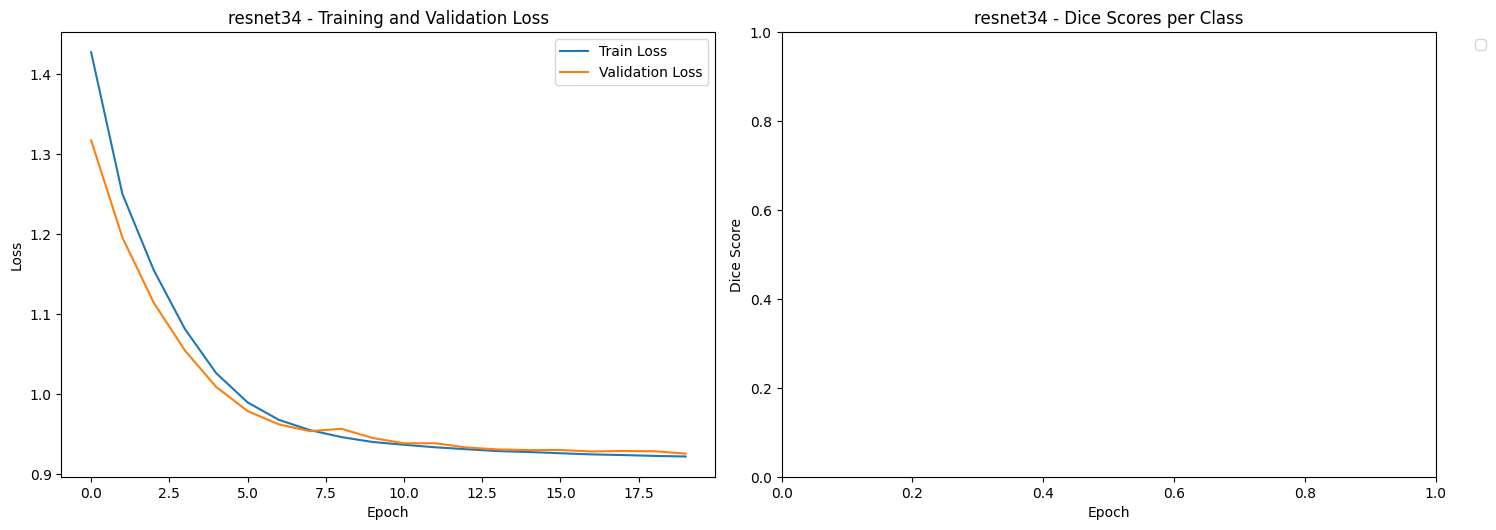

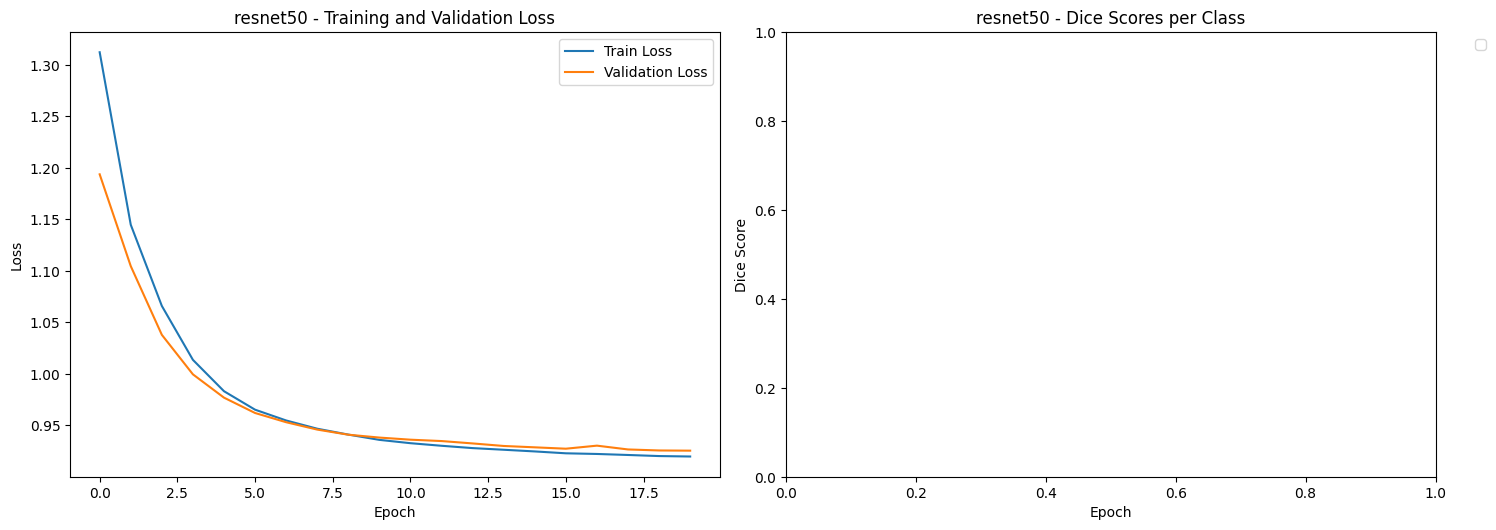

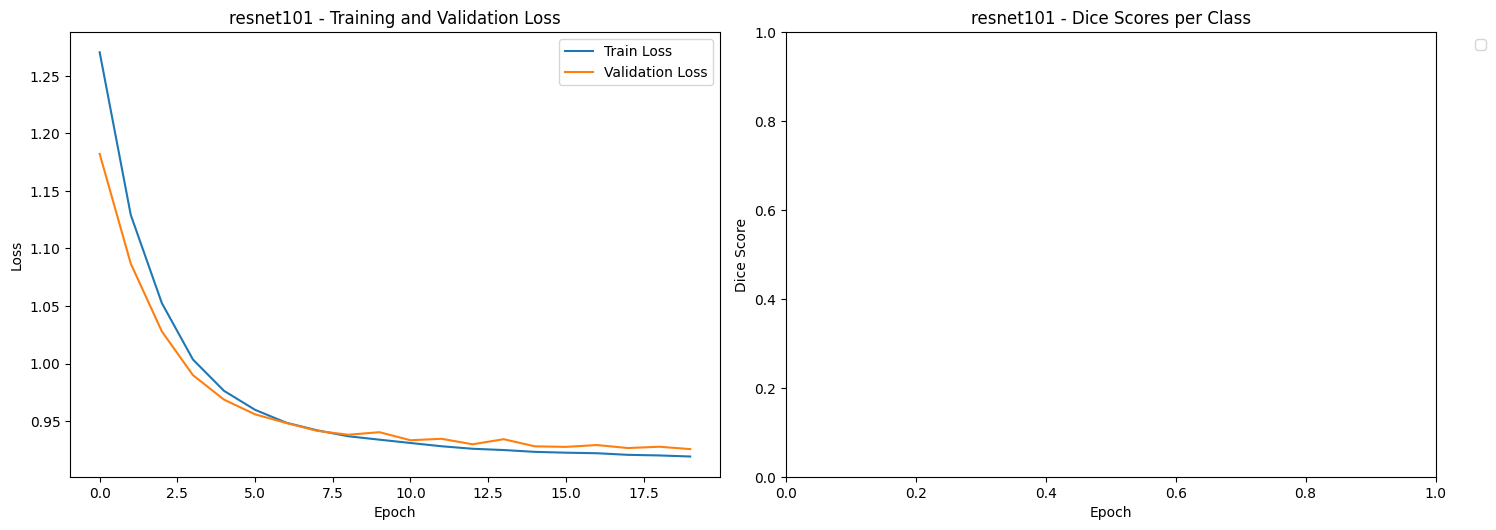

In [40]:
def plot_training_metrics(training_results, encoder_name):

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(training_results['train_loss'], label='Train Loss')
    plt.plot(training_results['val_loss'], label='Validation Loss')
    plt.title(f'{encoder_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    class_names = ['Intervertebral Disc', 'Posterior Element', 'Thecal Sac', 'AAP', 'Background']
    
    for cls in range(len(class_names)):
        if f'train_{class_names[cls].lower()}_dice' in training_results.columns:
            plt.plot(training_results[f'train_{class_names[cls].lower()}_dice'], 
                     label=f'Train {class_names[cls]}', linestyle='--')
        if f'val_{class_names[cls].lower()}_dice' in training_results.columns:
            plt.plot(training_results[f'val_{class_names[cls].lower()}_dice'],
                     label=f'Val {class_names[cls]}')
    
    plt.title(f'{encoder_name} - Dice Scores per Class')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.savefig(f'/kaggle/working/training_metrics_{encoder_name}.png')
    plt.show()
    plt.close()


training_results_resnet34 = pd.read_csv('/kaggle/working/training_results_resnet34.csv')
training_results_resnet50 = pd.read_csv('/kaggle/working/training_results_resnet50.csv')
training_results_resnet101 = pd.read_csv('/kaggle/working/training_results_resnet101.csv')

plot_training_metrics(training_results_resnet34, "resnet34")
plot_training_metrics(training_results_resnet50, "resnet50")
plot_training_metrics(training_results_resnet101, "resnet101")


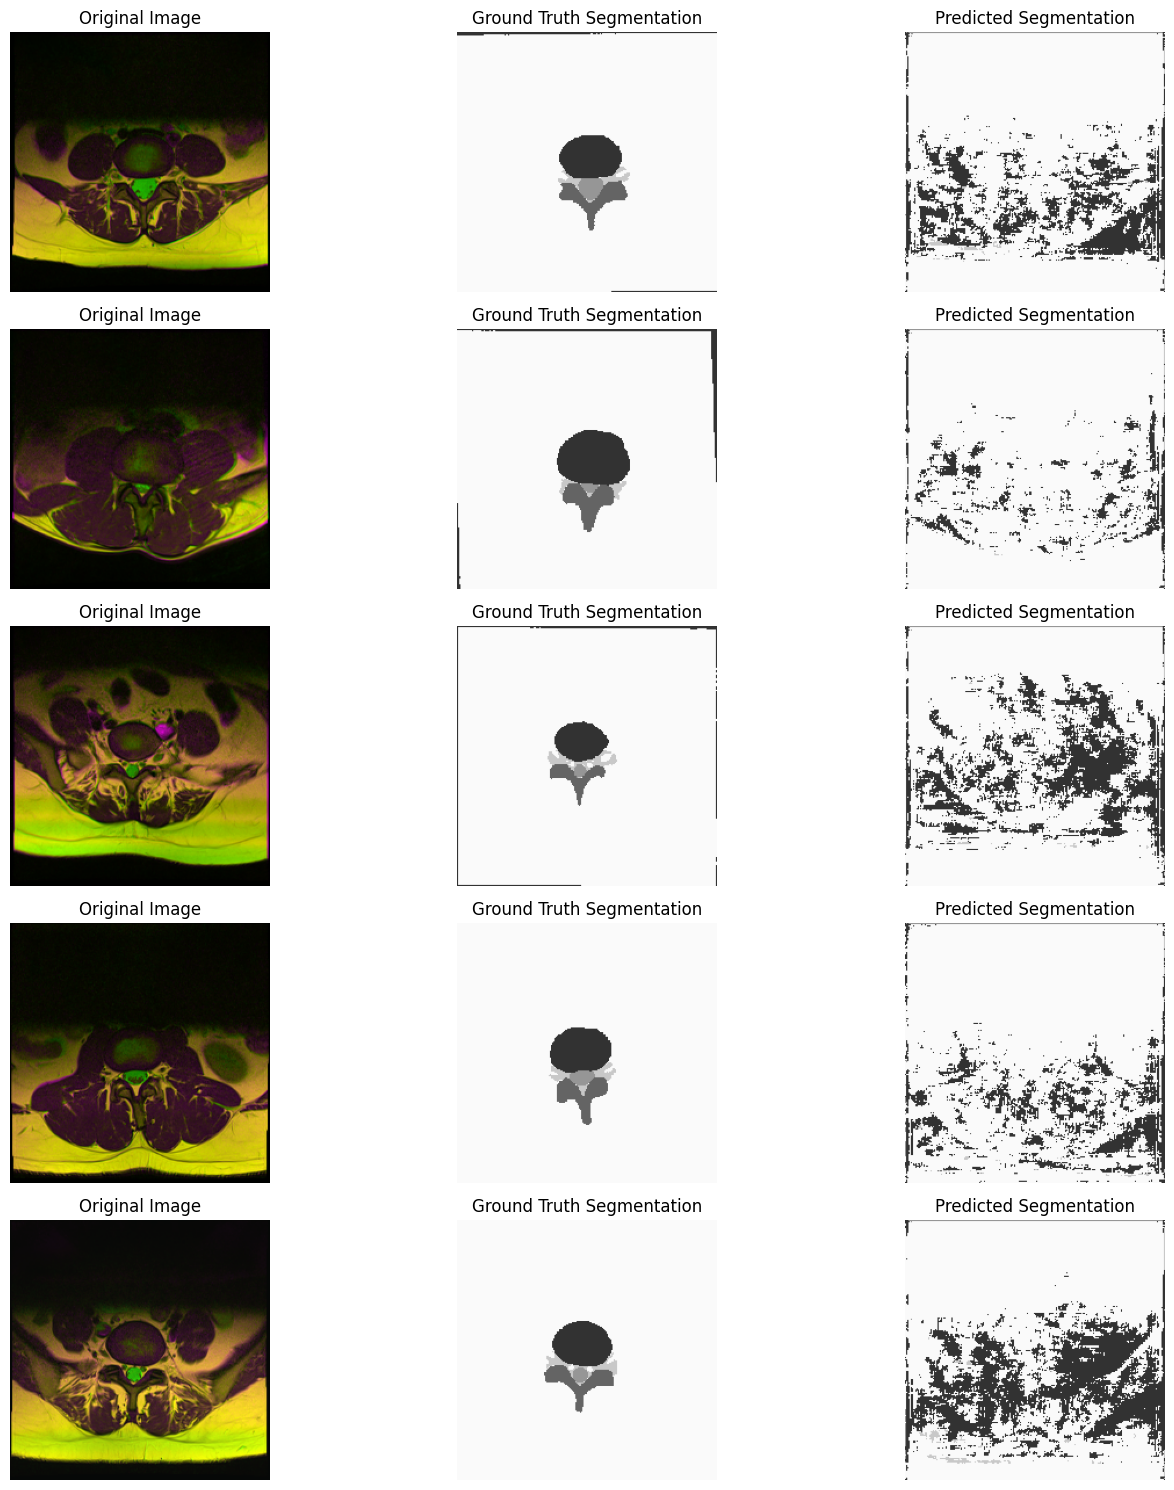

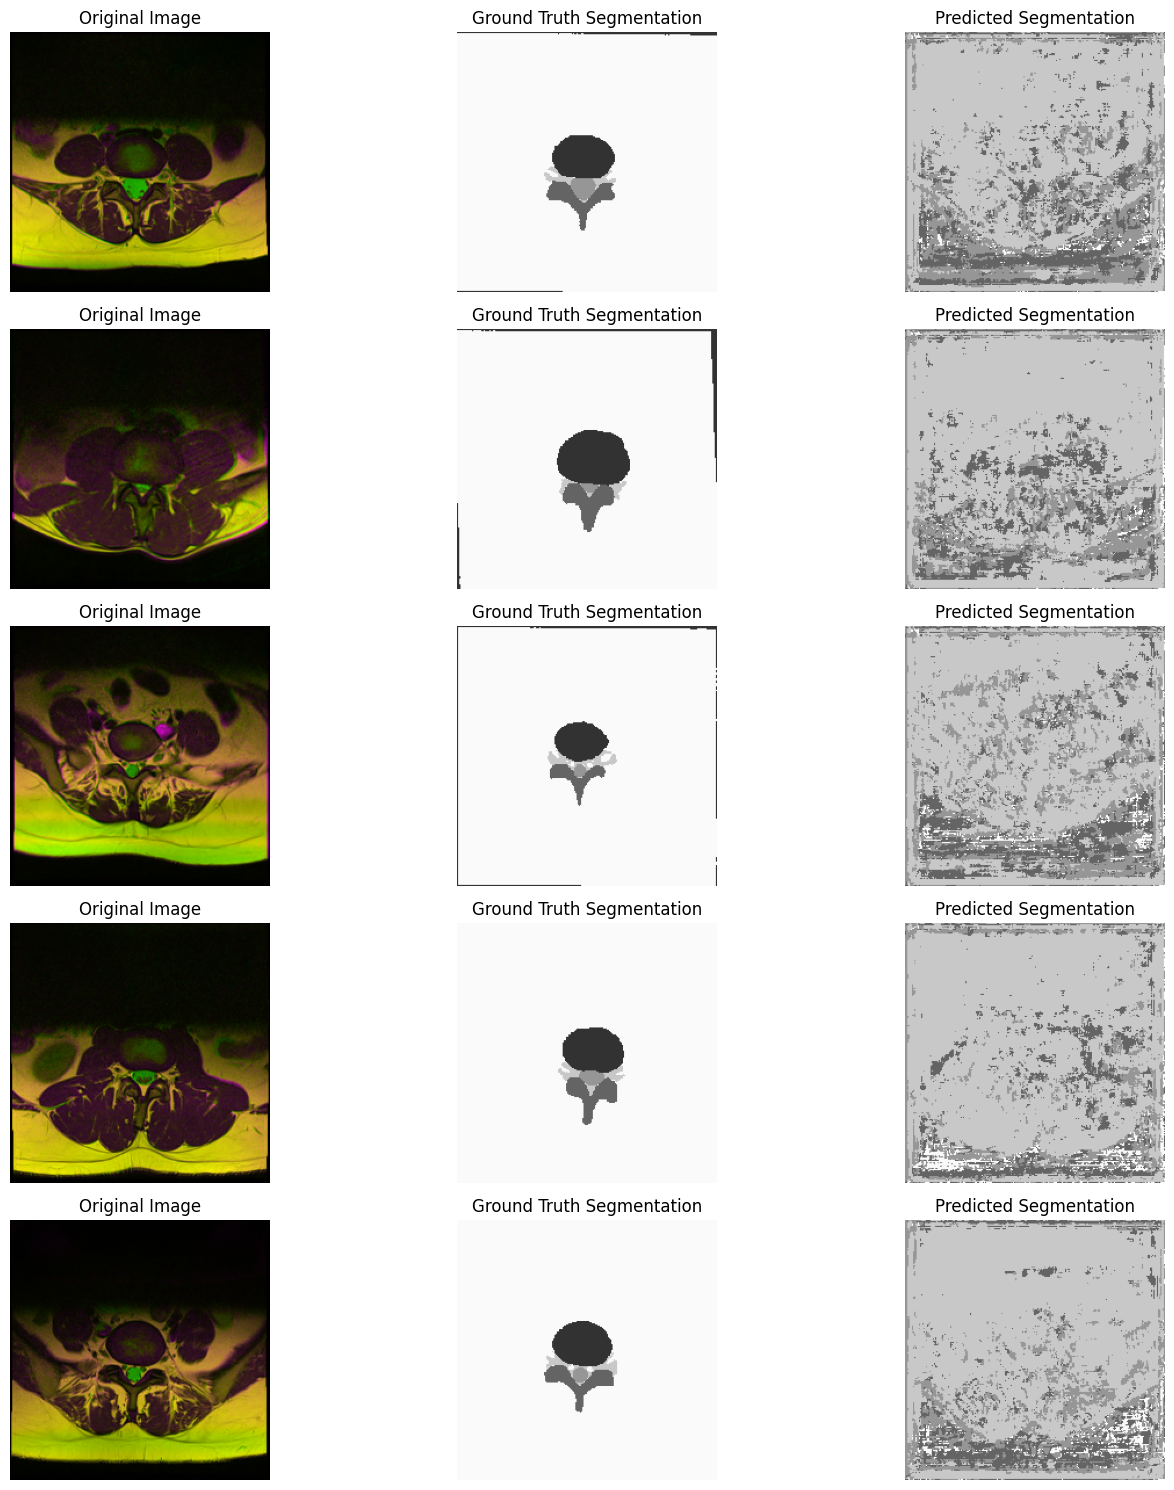

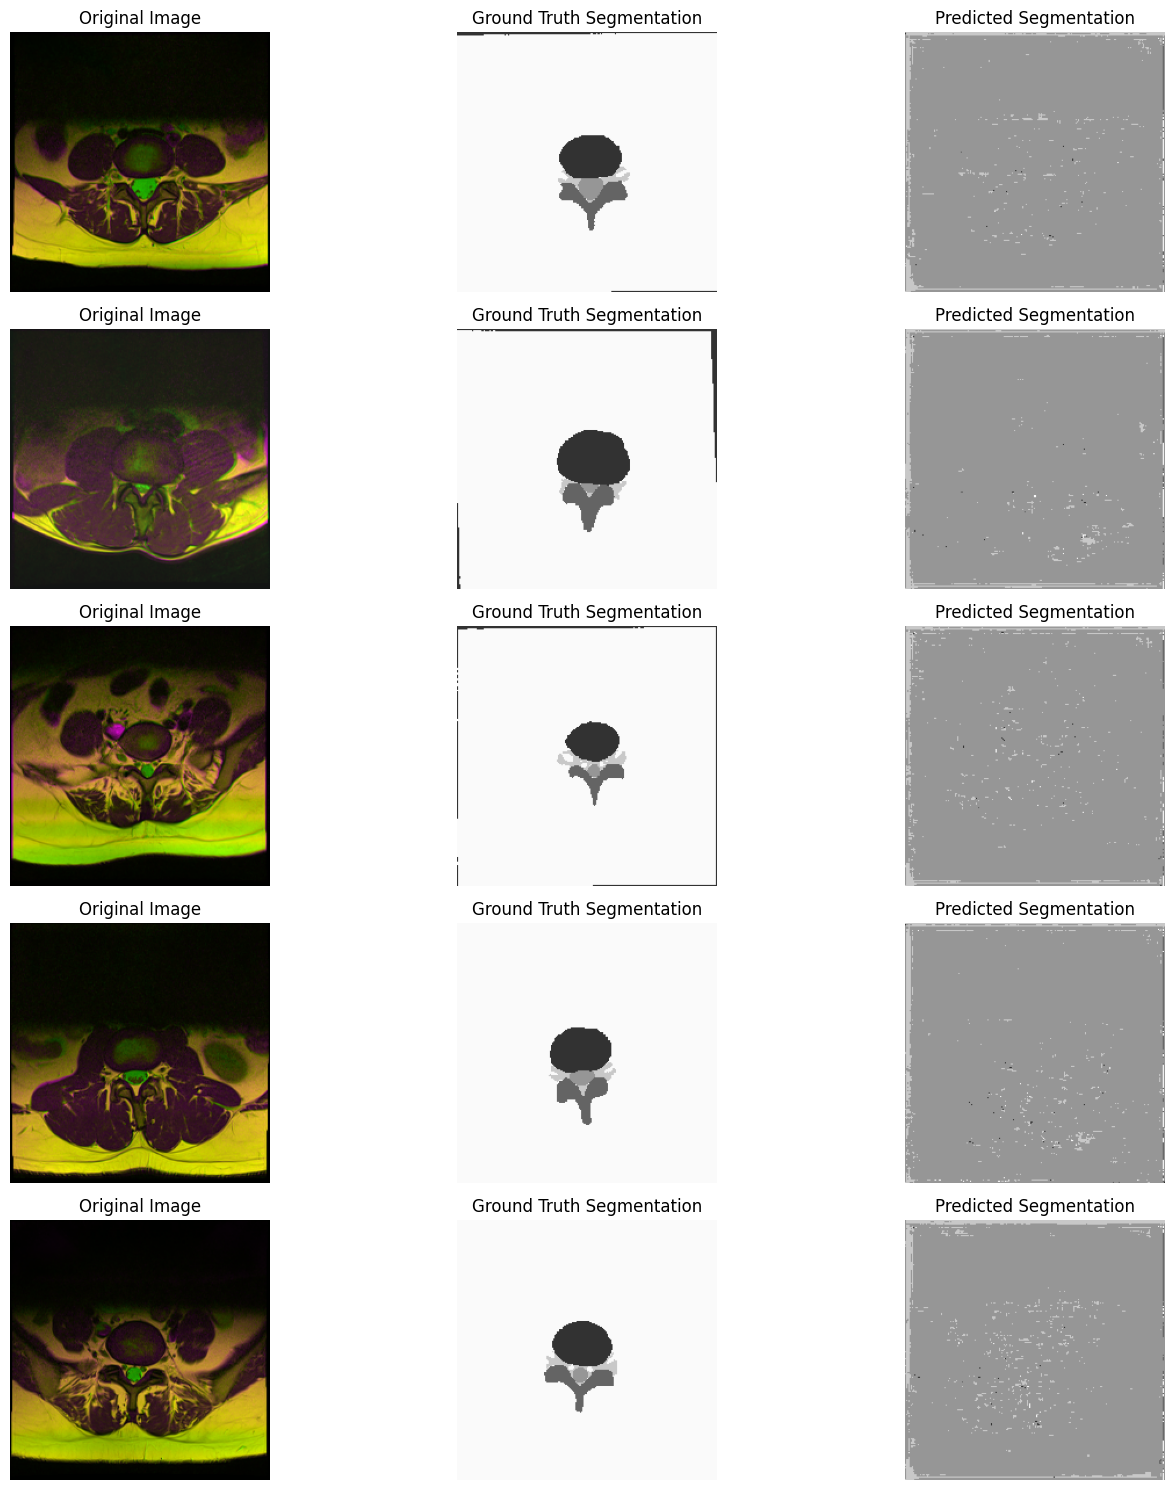

In [35]:
def visualize_segmentation_results(model, test_loader, device, num_samples=5):
    model.to(device)
    model.eval()
    
    class_colors = [
        (50, 50, 50),
        (100, 100, 100),
        (150, 150, 150),
        (200, 200, 200),
        (250, 250, 250)
    ]
    class_names = ['IVD', 'PE', 'TS', 'AAP', 'Background']
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()
            
            plt.figure(figsize=(15, 3 * num_samples))
            
            for i in range(min(num_samples, images.shape[0])):
                plt.subplot(num_samples, 3, 3*i + 1)
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                plt.imshow(img)
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(num_samples, 3, 3*i + 2)
                gt_mask = masks[i].cpu().numpy()
                colored_mask = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
                for cls, color in enumerate(class_colors):
                    colored_mask[gt_mask == cls] = color
                plt.imshow(colored_mask)
                plt.title('Ground Truth Segmentation')
                plt.axis('off')
                
                plt.subplot(num_samples, 3, 3*i + 3)
                pred_mask = predicted_classes[i]
                colored_pred_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
                for cls, color in enumerate(class_colors):
                    colored_pred_mask[pred_mask == cls] = color
                plt.imshow(colored_pred_mask)
                plt.title('Predicted Segmentation')
                plt.axis('off')
            
            plt.tight_layout()

            save_path = '/kaggle/working/segmentation_results.png'
            plt.savefig(save_path)

            plt.show()

            plt.close()
            break

for file_path in file_paths:
    test_results = pd.read_csv(file_path)
    
    encoder_name = file_path.split('_')[-2]
    if encoder_name not in ['resnet34', 'resnet50', 'resnet101']:
        encoder_name = 'resnet34'
    
    model = UNetPlusPlusWithAttention(encoder_name=encoder_name, in_channels=3, num_classes=5)
    model.to(Config.DEVICE)
    visualize_segmentation_results(model, test_loader, Config.DEVICE)


Processing encoder resnet34 with results: {0: 0.9566563218832016, 1: 0.8937254279851914, 2: 0.9257421731948853, 3: 0.7396376699209213, 4: 0.9951415061950684}
Processing encoder resnet50 with results: {0: 0.9545368671417236, 1: 0.9163856953382492, 2: 0.9200652688741684, 3: 0.7495855033397675, 4: 0.9956962704658509}
Processing encoder resnet101 with results: {0: 0.9551532506942749, 1: 0.9154511392116547, 2: 0.9221647590398788, 3: 0.7585877567529679, 4: 0.9957420408725739}
Dice scores matrix for heatmap: [[0.9566563218832016, 0.8937254279851914, 0.9257421731948853, 0.7396376699209213, 0.9951415061950684], [0.9545368671417236, 0.9163856953382492, 0.9200652688741684, 0.7495855033397675, 0.9956962704658509], [0.9551532506942749, 0.9154511392116547, 0.9221647590398788, 0.7585877567529679, 0.9957420408725739]]


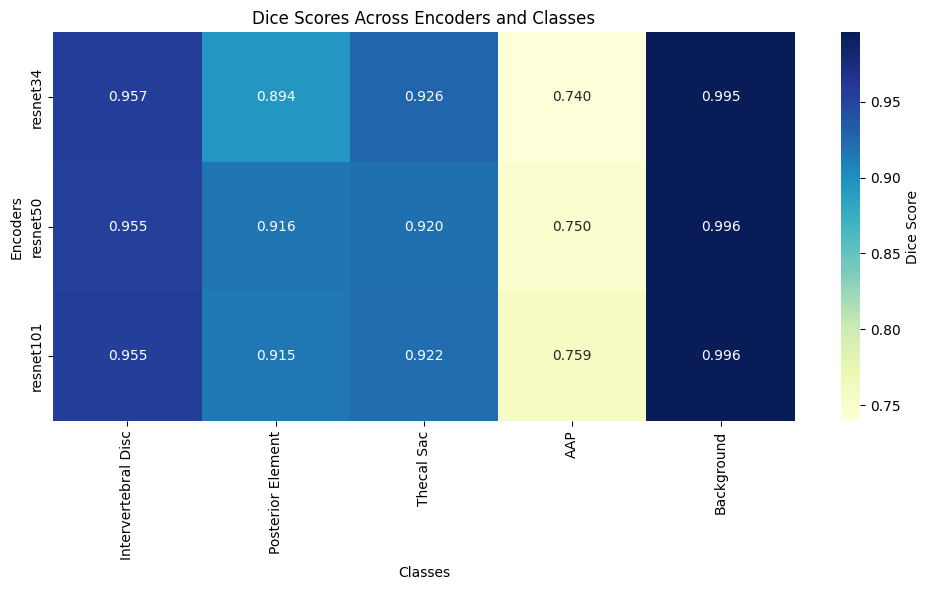

In [26]:
def plot_dice_score_heatmap(test_results):
    class_names = ['Intervertebral Disc', 'Posterior Element', 'Thecal Sac', 'AAP', 'Background']
    encoder_names = ["resnet34", "resnet50", "resnet101"]
    
    dice_scores = []
    
    for idx, result in enumerate(test_results):
        print(f"Processing encoder {encoder_names[idx]} with results: {result}")
        encoder_scores = [result.get(cls, 0) for cls in range(len(class_names))]
        dice_scores.append(encoder_scores)

    print(f"Dice scores matrix for heatmap: {dice_scores}")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        dice_scores, 
        annot=True, 
        cmap='YlGnBu', 
        xticklabels=class_names, 
        yticklabels=encoder_names,
        fmt='.3f',
        cbar_kws={'label': 'Dice Score'}
    )
    plt.title('Dice Scores Across Encoders and Classes')
    plt.xlabel('Classes')
    plt.ylabel('Encoders')
    plt.tight_layout()
    plt.show()

def parse_dict_string(data):
    try:
        return ast.literal_eval(data)
    except Exception as e:
        print(f"Error parsing string: {data}\nError: {e}")
        return {}

def load_and_process_results(file_paths):
    test_results = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['test_dice_scores'] = df['test_dice_scores'].apply(parse_dict_string)
        test_results.append(df['test_dice_scores'].iloc[0])
    return test_results


test_dice_scores = load_and_process_results(file_paths)
plot_dice_score_heatmap(test_dice_scores)
